# Rede Neural de jogos do OverWatch
O objetivo desse trabalho é criar uma Rede Neural com uma taxa de aprendizado melhor que o método de Regressão Logistica. Para isso utilizaremos o dataset  disponivel no Kaggle, caso esteja olhando pelo meu GitHub, esta disponivel na pasta "Dataset".

Para essa comparação iremos verificar qual será a função da equipe(ataque ou defesa).Essa previsão ,por exemplo, seria util caso queiramos indicar para um usuario especifico a função que ele geralmente exerce quando joga com sua equipe. Por exemplo Lacerda_jp sempre quando está no mesmo time de Alvim_leandro joga de ataque, logo futuramente com esse aprendizado poderiamos sempre que Lacerda_jp tivesse no mesmo time já indicasse que a equipe jogasse atacando.

### Index
1. Tratando o dataset
2. Dividindo os dados
3. Treinando a Rede Neural
4. Treinando a Regressão Logistica
5. Resultados

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score
import seaborn as sns
import matplotlib.pyplot as pl
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import LabelEncoder
from sklearn.neural_network import MLPClassifier

### Tratando o Dataset
Como dito no inicio do Relatorio, estamos usando o Dataset disponivel no Kaggle no seguinte link:
 https://www.kaggle.com/datasets/mylesoneill/overwatch-game-records/data?select=overwatch-diary.csv
Já extrai o data set e estou usando na Pasta Dataset do repositorio Github:
    https://github.com/Lacerdajp/AnaliseOverWatch
Assim  através da biblioteca pandas, leio o dataset para o programa:
 

In [14]:
dataset=pd.read_csv("./Dataset/overwatch-diary.csv")
print("Dados da coluna Team Role:",dataset['team_role'].unique())

Dados da coluna Team Role: ['CP' 'Attack' 'Defend' '-' nan 'Defense' 'w' 'defense' 'ATtack']


Após pegar o dataset, devemos tratar os dados. Esse tratamento é importante pois é aqui que iremos purificar os dados para conseguirmos trabalhar eles,deixando-o padroizado.O dataset utilizado há alguns defeitos, pois não são dados totalmente claros, dificultando um pouco o aprendizado. Tendo ele diversos defeitos como não está padronizado,com falta de dados, linhas zeradas, erros de Padrão de palavras entre diversas coisas. 

Sendo assim padronizei os dados de acordo com a coluna que irei realizar o aprendizado, retirando a linhas que tem dados do tipo notNumber, a string '-'(cujo não faz sentido um time não ter uma função) e 'CP' que não tem claridade o que significa.Depois de retirar essas linhas que não faz muito sentido ao noso aprendizado, transformei todos os dados da coluna  em letras minusculas para padronizar o nome do dado. Depois disso substitui palavras com o mesmo sentido semantico da coluna (por exemplo 'defense' e 'defend'), e 'w' que era o mesmo que atack:

In [15]:
dataset['team_role'].fillna('-',inplace=True)
dataset=dataset[(dataset['team_role']!='CP') & (dataset['team_role']!='-') ]
dataset['team_role']=[x.lower() for x in dataset['team_role']]
dataset['team_role'].replace('defense','defend',inplace=True)
dataset['team_role'].replace('w','attack',inplace=True)


### Dividindo os dados

Depois de tratar os dados de aprendizado é necessario  dividir os dados, afim de separar a coluna que estamos aprendendo sobre e os dados que influenciam nela. Sendo y nossa coluna de aprendizado e x as demais colunas do dataset. 

In [16]:
x=dataset.drop('team_role',axis=1)
y=dataset['team_role']

Após dividir esses dados em x e y, é muito importante tratar esses dados para  conseguir identificar numericamente eles, dando um código para cada string. Por isso é ultilizado a class LabelEncoder que basicamente faz isso para nós, ultilizando o método fit_transform().O for nas colunas de x é importante pois o metodo é utilizado apenas para os valores de apenas uma coluna.

In [17]:
le = LabelEncoder()
x_encoded = x.copy()
for column in x.columns:
    x_encoded[column] = le.fit_transform(x[column])
y_encoded = le.fit_transform(y)




Aqui devemos iremos dividir os dados em 3 tipos de ambientes : Treino, Desenvolvimento, Teste. Esses dados em primeira mão serão repartidos em 2 sendo 70% para treino e o restante para um ambiente temporario. Esse ambiente temporario será repartido em 2 de partes iguais, sendo um o ambeinte de desenvolvimento e outro de teste

Os Dados de treinos serão a maior parte de dados que temos, eles serão usados para o algoritmo ultilizado na biblioteca MLPClassifier  aprender como é o funcionamento dos dados de y perante aos dados de x.

Os dados do ambiente de desenvolvimento serão metade dos dados temporarios ou seja aproximadamente 15% dos dados totais.Ele será responsavel  para ajustar os hiperparamtros o modelo treinado, afim melhorar ainda mais a eficacia do nosso modelo

Por fim o ambiente de teste cujo o objetivo principal é comparar os dados que nosso modelo calculou, de acordo com o aprendizado feito  no ambiente de treino e dos ajustes do ambiente de desenvolvimento, com dados reais.Eles assim como o desenvolvimento serão 15% dos dados totais.



In [18]:
X_train, X_temp, y_train, y_temp= train_test_split(x_encoded, y_encoded, test_size=0.3, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
# Verificar o tamanho dos conjuntos
print("Tamanho do ambiente de treino: x=", len(X_train),"y=", len(y_train))
print("Tamanho do ambiente de desenvolvimento: x=", len(X_dev),"y=", len(y_dev))
print("Tamanho do ambiente de teste: x=", len(X_test),"y=", len(y_test))



Tamanho do ambiente de treino: x= 2003 y= 2003
Tamanho do ambiente de desenvolvimento: x= 429 y= 429
Tamanho do ambiente de teste: x= 430 y= 430


### Treinando a Rede Neural
Primeiramente iremos treinar nosso modelo pra isso usaremos o MLPClassifier para relizar o treinamento efetivo da aplicação. usaremos os dados de treino e um numero maximo de interaçoes de 500. muito importante ter o treinamento do modelo para que possamos ajustar esse modelo depois com os hiperparametros.


In [19]:
model = MLPClassifier( max_iter=500, random_state=42)
model.fit(X_train, y_train)

MLPClassifier(max_iter=500, random_state=42)



Após treinar e necessario achar os melhores parametros pra realizar o testes,e por isso ultilizaremos o desenvolvimento. Usaremos RandomizedSearchCV para pegar nosso modelo treinado calibrar ele para que possamos usar os casos de teste, essa calibragem nos fará ultilizar os melhores parametros. esses ajustes de parametros serão avaliados pela pontuação de acuracia , para pegar o melhor parametro ultilizaremos no teste e ajustar o que for necesario, por isso faremos o ambiente de desenvolvimento. Após isso iremos ver os melhores parametros e metricas. 

$Acuracia=\frac{ValCorretos}{ValTotais}$

       

In [20]:

param_dist = {
   'hidden_layer_sizes': [(50,), (100,), (150,)],
    'activation': ['logistic', 'tanh', 'relu'],
    'learning_rate_init': [0.001, 0.01, 0.1],
}
random_search = RandomizedSearchCV(model, param_distributions=param_dist, scoring='accuracy', n_iter=10, cv=3, random_state=42)
random_search.fit(X_dev, y_dev)
best_mlp = random_search.best_estimator_


Depois de achar os melhores parametros do modelo devemos treinar novamente, afim do nosso novo modelo( com os melhores parametros) aprenda sobre o comportamento dos dados novamente para por fim testar nosso modelo. A partir daqui precisaremos normalizar os dados da coluna x. Isso é transformar em valores classificaveis, por isso usaremos o metodo Zscore(StandadScler). Normalizando todos os dados de X

In [21]:
scaler = StandardScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_dev_scaled= scaler.transform(X_dev)
X_test_scaled= scaler.transform(X_test)


Por fim ao realizarmos a normalização, treinamos nosso modelo com os melhores parametros e por fim testamos ele e avaliamos os valores de testes com os valores reais com acuracia e macro F1 gerando assim dois valores de porcentagem de acordo com cada metododologia

In [22]:

best_mlp.fit(X_train_scaled, y_train)

y_test_pred_mlp = best_mlp.predict(X_test_scaled)
accuracy_mlp = accuracy_score(y_test, y_test_pred_mlp)
macroF1_mlp = f1_score(y_test, y_test_pred_mlp, average='macro')

print("Desempenho do melhor modelo de Rede Neural:")
print("Acurácia: ",accuracy_mlp,"ou",accuracy_mlp*100,"%")
print("Macro F1: ",macroF1_mlp,"ou",macroF1_mlp*100,"%")

Desempenho do melhor modelo de Rede Neural:
Acurácia:  0.627906976744186 ou 62.7906976744186 %
Macro F1:  0.6243229075659619 ou 62.43229075659619 %


### Treinando a Regressão Logistica
Em suma esse metodo é muito mais simples pois apenas precisamos treinar o modelo de regressão logistica ultilizando os dados normalizados, que ja mostramos anteriormente, e depois testa-los. A diferença se mostra que aqui não temos parametros para ajustar para melhorar nossa proximidade de uma realidade. Sendo assim tem menos acertividade em teroria.
Por isso aqui treinamos e testamos e calculamos os valores de acuracia e macroF1 afim de comparar a acertibilidade com a do nosso modelo de redes neurais.

In [23]:


logistic_model = LogisticRegression(random_state=42,max_iter=500)
logistic_model.fit(X_train_scaled, y_train)

y_test_pred_logistic = logistic_model.predict(X_test_scaled)
accuracy_logistic = accuracy_score(y_test, y_test_pred_logistic)
macroF1_mlp = f1_score(y_test, y_test_pred_logistic, average='macro')
print("Desempenho do modelo de Regressão Logística:")
print("Acurácia:",accuracy_logistic,"ou",accuracy_logistic*100,"%")
print("Macro F1:",macroF1_mlp,"ou",macroF1_mlp*100,"%")


Desempenho do modelo de Regressão Logística:
Acurácia: 0.5069767441860465 ou 50.697674418604656 %
Macro F1: 0.5045652173913043 ou 50.45652173913043 %


### Resultados
Por fim, podemos concluir que o nosso objetivo de provar que nosso modelo foi superior a regressão Logistica. Podemos ver  a baixo a matriz confusão e as estatisticas de treinos de alguns modelos .

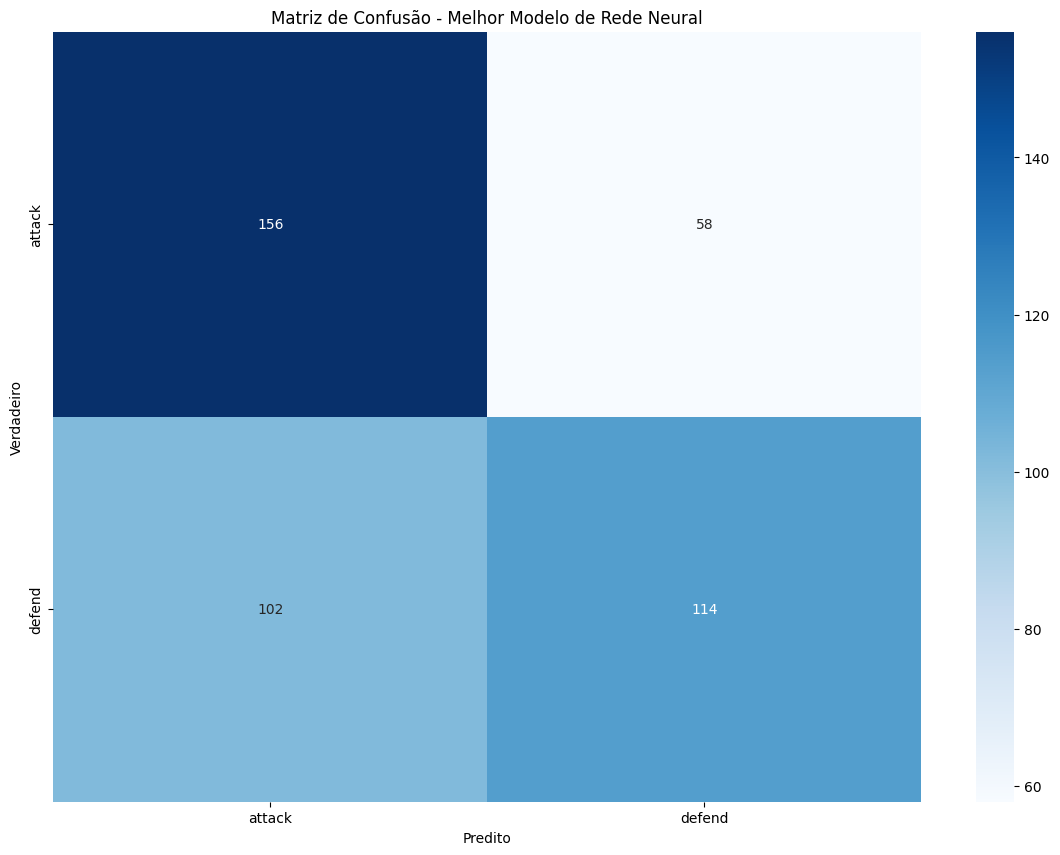

              precision    recall  f1-score   support

      attack       0.60      0.73      0.66       214
      defend       0.66      0.53      0.59       216

    accuracy                           0.63       430
   macro avg       0.63      0.63      0.62       430
weighted avg       0.63      0.63      0.62       430

Acurácia:  0.627906976744186 ou 62.7906976744186 %
Macro F1:  0.5045652173913043 ou 50.45652173913043 %


In [24]:
hero_labels = y.unique()
conf_matrix_mlp = confusion_matrix(y_test, y_test_pred_mlp)
classification_rep_mlp = classification_report(y_test, y_test_pred_mlp,target_names=hero_labels)
# Criar DataFrame com os rótulos corretos
conf_matrix_df_mlp = pd.DataFrame(conf_matrix_mlp, index=hero_labels, columns=hero_labels)

# Plotar a matriz de confusão usando seaborn
pl.figure(figsize=(14, 10))
sns.heatmap(conf_matrix_df_mlp, annot=True, fmt='d', cmap='Blues', cbar=True)
pl.title('Matriz de Confusão - Melhor Modelo de Rede Neural')
pl.xlabel('Predito')
pl.ylabel('Verdadeiro')
pl.show()
print(classification_rep_mlp)

print("Acurácia: ",accuracy_mlp,"ou",accuracy_mlp*100,"%")
print("Macro F1: ",macroF1_mlp,"ou",macroF1_mlp*100,"%")

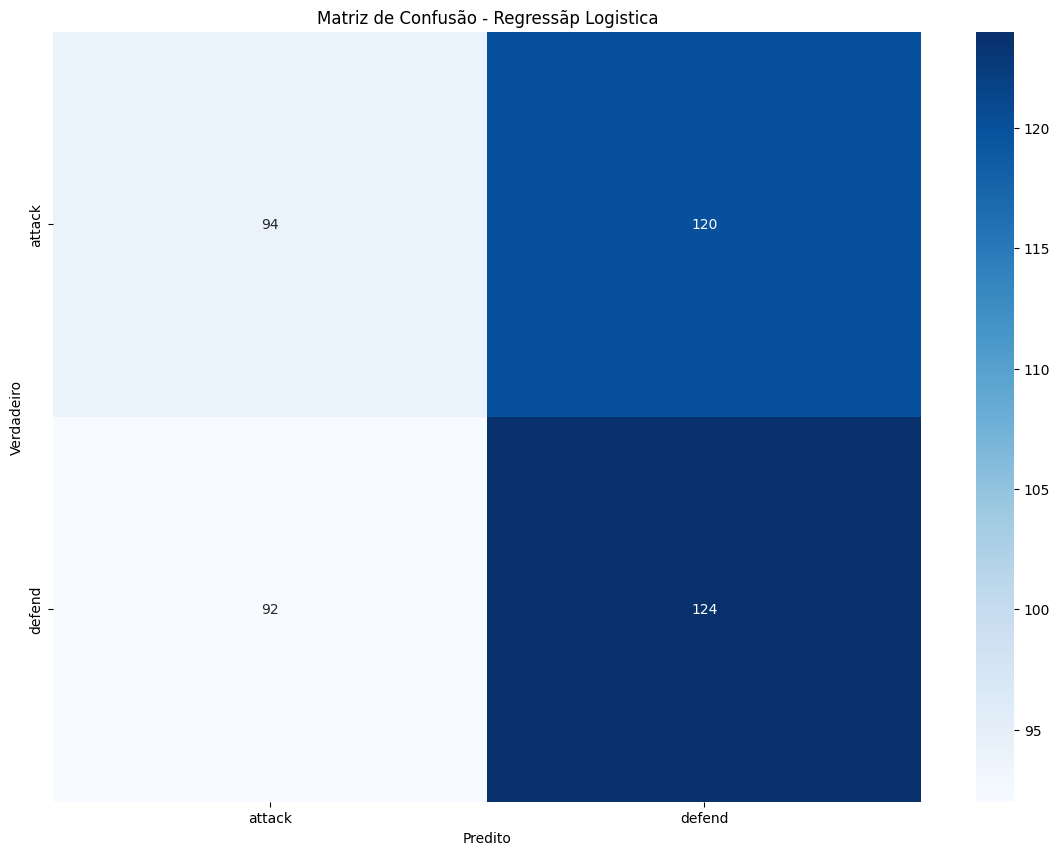

              precision    recall  f1-score   support

           0       0.51      0.44      0.47       214
           1       0.51      0.57      0.54       216

    accuracy                           0.51       430
   macro avg       0.51      0.51      0.50       430
weighted avg       0.51      0.51      0.50       430

Acurácia: 0.5069767441860465 ou 50.697674418604656 %
Macro F1: 0.5045652173913043 ou 50.45652173913043 %


In [25]:
hero_labels = y.unique()
conf_matrix_logistics = confusion_matrix(y_test, y_test_pred_logistic)
classification_rep_Logistic = classification_report(y_test, y_test_pred_logistic)
# Criar DataFrame com os rótulos corretos
conf_matrix_df_logistics = pd.DataFrame(conf_matrix_logistics, index=hero_labels, columns=hero_labels)

# Plotar a matriz de confusão usando seaborn
pl.figure(figsize=(14, 10))
sns.heatmap(conf_matrix_df_logistics, annot=True, fmt='d', cmap='Blues', cbar=True)
pl.title('Matriz de Confusão - Regressãp Logistica')
pl.xlabel('Predito')
pl.ylabel('Verdadeiro')
pl.show()

print(classification_rep_Logistic)

print("Acurácia:",accuracy_logistic,"ou",accuracy_logistic*100,"%")
print("Macro F1:",macroF1_mlp,"ou",macroF1_mlp*100,"%")

